In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [2]:
#Bước 1: Load data
def load_dataset():
    X, y = load_iris(return_X_y=True)
    X = X[y!=2]
    y = y[y!=2]
    return X,y

x, y = load_dataset()
print(x.shape, y.shape)

(100, 4) (100,)


Kết quả: (100, 4) (100,)

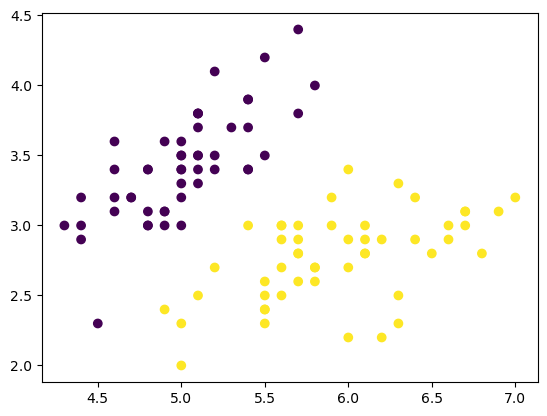

In [3]:
plt.scatter(x[:, 0], x[:, 1], c = y)
plt.show()

Kết quả

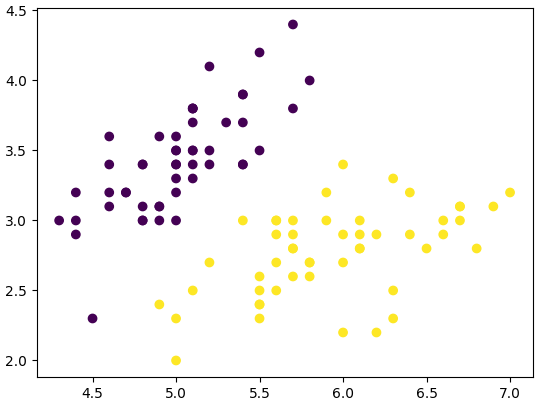

In [4]:
# Bước 2: Định nghĩa mô hình hồi quy logistic bằng PyTorch
class LogisticRegressTorch(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegressTorch, self).__init__()
        # tạo một lớp tuyến tính (nn.Linear) với n_features đầu vào và 1 đầu ra
        self.linear = nn.Linear(n_features, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))


+ Mô hình LogisticRegression hoạt động như sau:
+ Mô hình: y' = wx + b
1. Khởi tạo trọng số w và b
2. Thực hiện lấy một sample trong tập dữ liệu train để tính y'
3. Sau đó đưa giá trị y' qua hàm Sigmoid
4. Bắt đầu tính Loss function (Binary Cross Entropy)
5. Tính đạo hàm của w và b
6. Cập nhật trọng số của w và b xong bắt đầu quay lại bước 2.


In [5]:
# Bước 3: Định nghĩa lớp dữ liệu
class IrisTorch(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)            
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]   #trả về một cặp đặc trưng và nhãn tương ứng với chỉ số idx

In [6]:
# Tạo dữ liệu
dataset = IrisTorch(x, y)

In [7]:
# Bước 4: Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra bằng cách chia ngẫu nhiên 70,30.
train_size = int(0.7 * dataset.__len__())                                         #70%
test_size = int(0.3 * dataset.__len__())                                          #30%
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [23]:
# Tạo DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [24]:
# Bước 5: Định nghĩa criterion và optimizer
n_features = x.shape[1]
model = LogisticRegressTorch(n_features = n_features)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

+ Phân tích nếu thay criterion bằng CrossEntropyLoss giá trị sẽ sai.
+ Đối với mô hình Logistic Regression thì sẽ sử dụng Binary Cross Entropy thay vì CrossEntropyLoss vì:
- Đối với CrossEntropyLoss thì hàm đã được tích hợp sẵn hàm softmax. Nó sẽ lấy giá trị của layer cuối cùng (output) không cần tính softmax. Nếu dùng CrossEntropy thì khi qua hàm sigmoid xong thì chúng sẽ lại tiếp tục qua hàm softmax nữa sau đó mới ra kết quả cuối cùng. Điều này dẫn tới kết quả sai. Bởi vì đối với Logistic Regression thì sau khi tính được giá trị dự đoán thì chúng ta chỉ cần hàm loss thông thường để tính giá trị loss không cần phải đi thêm bất kì hàm kích hoạt nào nữa.
- Tóm lại thì hàm BCELoss thường sẽ được dùng trong mô hình Logistic Regression và ngược lại đối với mô hình Softmax Regression và các mô hình MLP thì sẽ dùng CrossEntropyLoss.

In [25]:
# Huấn luyện mô hình
n_epochs = 100
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    total = 0.0
    correct = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item() * inputs.size(0)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Đánh giá trên tập kiểm tra
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            predicted = (outputs >= 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/100, Train Loss: 0.6412, Test Loss: 0.6395, Test Accuracy: 0.5000
Epoch 2/100, Train Loss: 0.6289, Test Loss: 0.6293, Test Accuracy: 0.5000
Epoch 3/100, Train Loss: 0.6167, Test Loss: 0.6024, Test Accuracy: 0.5000
Epoch 4/100, Train Loss: 0.5919, Test Loss: 0.5981, Test Accuracy: 0.5000
Epoch 5/100, Train Loss: 0.5866, Test Loss: 0.5855, Test Accuracy: 0.5000
Epoch 6/100, Train Loss: 0.5741, Test Loss: 0.5748, Test Accuracy: 0.5000
Epoch 7/100, Train Loss: 0.5628, Test Loss: 0.5594, Test Accuracy: 0.5000
Epoch 8/100, Train Loss: 0.5489, Test Loss: 0.5579, Test Accuracy: 0.5000
Epoch 9/100, Train Loss: 0.5460, Test Loss: 0.5446, Test Accuracy: 0.5333
Epoch 10/100, Train Loss: 0.5330, Test Loss: 0.5339, Test Accuracy: 0.6333
Epoch 11/100, Train Loss: 0.5229, Test Loss: 0.5289, Test Accuracy: 0.6333
Epoch 12/100, Train Loss: 0.5179, Test Loss: 0.5238, Test Accuracy: 0.6333
Epoch 13/100, Train Loss: 0.5121, Test Loss: 0.5122, Test Accuracy: 0.9000
Epoch 14/100, Train Loss: 0.5009, 

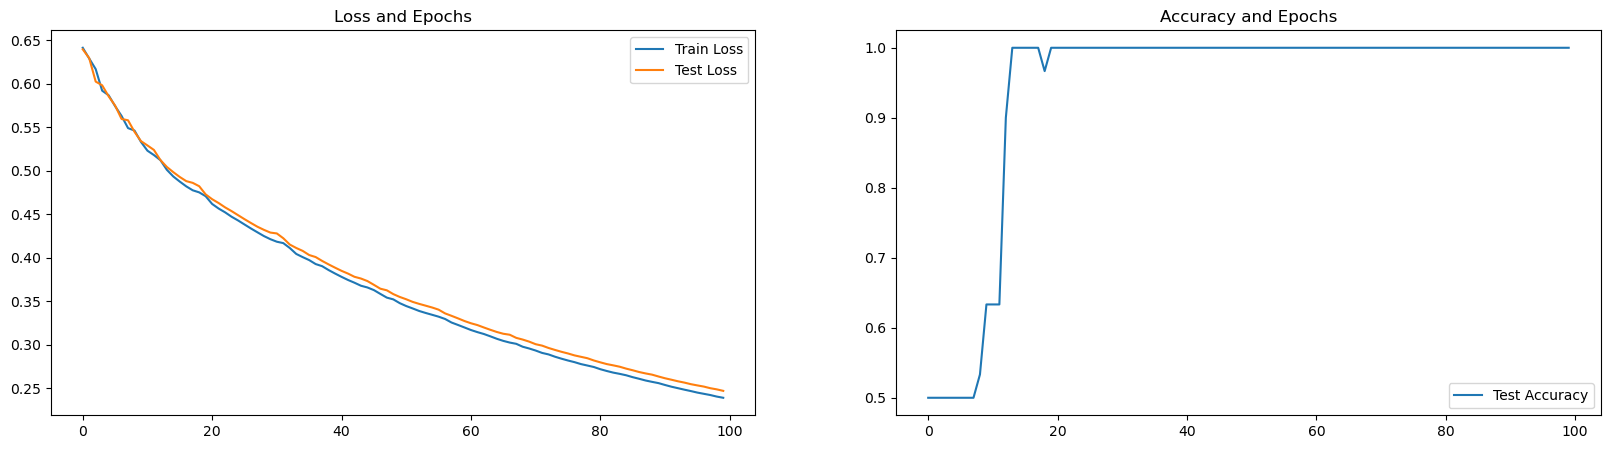

In [31]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss and Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy and Epochs')
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.legend()
plt.show()


#Kết quả:

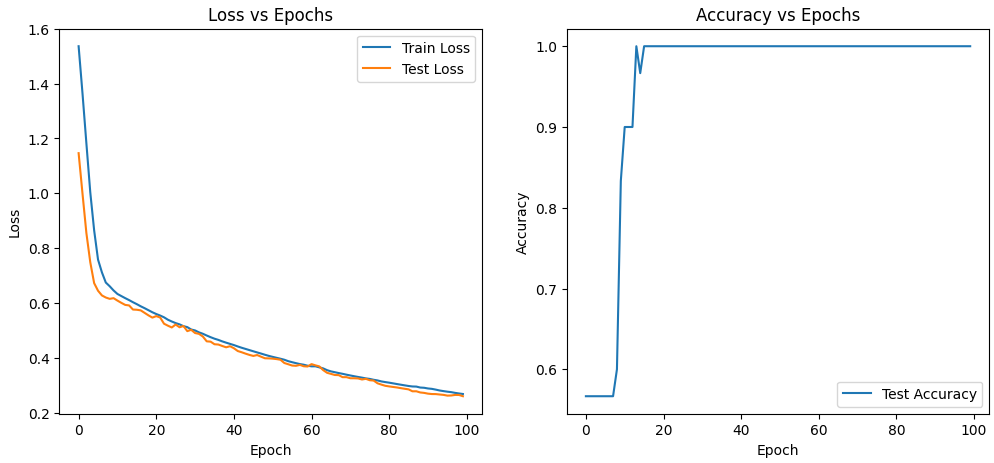